In [243]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
from tqdm import tqdm, trange
rng = np.random.default_rng()

### Генерация случайного графа в рамках конфигурационной модели

Сгенерируем граф, у которого распределение по степеням вершин является распределением Пуассона: $p_k = e^{-\lambda} \cfrac{\lambda^k}{k!}$. Также будет удобно сразу описать генерацию "предпочтений" агентов и динамику системы: каждый агент максимизирует свою функцию полезности
$$
    U_i(\sigma_i) = H \sigma_i + H_i \sigma_i + J \sum_j g_{ij}\sigma_i \sigma_j + \varepsilon_{\sigma_i}.
$$
На каждом шаге случайно разыгрываются $\varepsilon_{\sigma_i}$, после чего агенты делают выбор исходя из собственных предпочтнений $H_i$ и решений соседей на предыдущем шаге. 

In [246]:
class RandomPoissonGraph:
    def __init__(self, N=1000, l=5):
        self.N = N
        self.l = l
        degrees = sps.poisson.rvs(l, size=N)
        if np.sum(degrees) % 2 == 1:
            degrees = np.insert(degrees, degrees.size, 1)
            self.N += 1
        half_edges = []
        for num, deg in enumerate(degrees):
            half_edges += [num] * deg
        self.edges = len(half_edges) // 2
        self.state = -np.ones(self.N)

        first_indices = rng.choice(self.edges * 2, self.edges)
        second_indices = []
        current_pos = 0
        for i in range(2 * self.edges):
            if first_indices[current_pos] == i:
                current_pos += 1
            else:
                second_indices.append(i)
        permutation = rng.permutation(self.edges)
        self.connections = [[] for _ in range(self.N)]
        for i, index in enumerate(first_indices):
            v_first, v_second = half_edges[index], half_edges[second_indices[permutation[i]]]
            self.connections[v_first].append(v_second)
            self.connections[v_second].append(v_first)
            
    def print_connections(self):
        for i in range(min(self.N, 10)):
            print(i, ": ", sep='', end='')
            for neighbour in self.connections[i]:
                print(neighbour, end=' ')
            print()
            
    def set_state(self, state):
        G.state = state

    def sample_fields(self, distribution=sps.norm(loc=0, scale=1), multivariate=False):
        size = 1 if multivariate else self.N
        self.fields = distribution.rvs(size=size)

    def __get_noise(self, noise_distr):
        self.noise = noise_distr.rvs(size=(2, self.N))

    def get_next_state(self, H, J, noise_distr=sps.bernoulli(p=0)):
        self.__get_noise(noise_distr)
        utility = H + self.fields
        for agent in range(self.N):
            utility[agent] += J * np.sum(self.state[self.connections[agent]])
        temp = utility * np.array([[-1], [1]]) + self.noise
        self.state = 2 * np.argmax(utility * np.array([[-1], [1]]) + self.noise, axis=0) - 1
        return self.state

### Исследование динамики системы для нормально распределённых $H_i$ (1-мерный случай)

Сгенерируем случайный граф. Параметр распределения выберем таким, чтобы в графе была гигантская компонента связности: $\langle k^2 \rangle - 2\langle k \rangle > 0$ (критерий Моллоя-Рида, $k$ — степень вершины). Для распределения Пуассона с параметром $\lambda$ среднее число соседей $\langle k \rangle = \lambda$, а $\langle k^2 \rangle = \lambda^2 + \lambda$, поэтому необходимо $\lambda^2 > \lambda$. Видно, что можно взять любой параметр, больший $1$. Выберем, например, $\lambda = 5$ — тогда у каждой вершины будет в среднем по $5$ соседей. 

In [167]:
N = 10000
l = 5
J = 0.2
H_min, H_max = -3, 3
H_grid = np.linspace(H_min, H_max, 400)

In [156]:
G = RandomPoissonGraph(N, l)

В первой части этой задачи шум отсутствует ($\varepsilon_{\pm 1, i} \equiv 0 \: \forall \, i$), а отдельные поля $H_i \sim \mathcal{N}(0, 1)$.

In [157]:
G.sample_fields()

Будем плавно увеличивать $H$ от $H_{min}$ до $H_{max}$: при этом доля положительных спинов должна увеличиваться от $0$ при очень малых $H$ до $1$ при очень больших. Затем наоборот, будем постепенно уменьшать $H$ и, соответственно, долю положительно повёрнутых спинов.

In [258]:
def get_stable_state(G, H, J):
    current_state = G.state
    next_state = G.get_next_state(H, J)
    while not np.allclose(current_state, next_state):
        current_state = next_state
        next_state = G.get_next_state(H, J)
    return G.state

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [03:21<00:00,  1.99it/s]


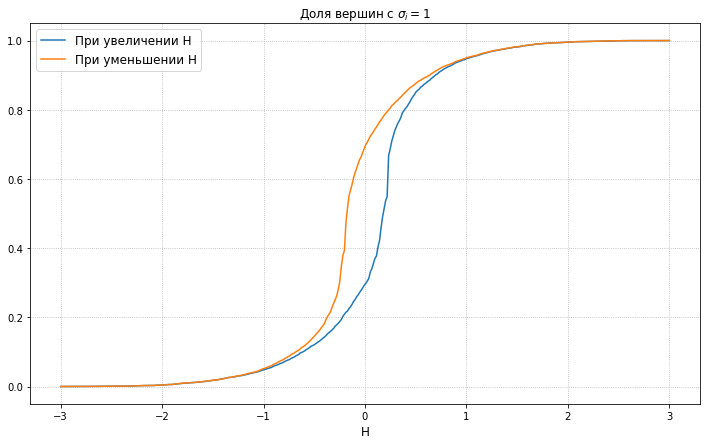

In [159]:
low_to_high_fractions = []
for H in tqdm(H_grid):
    new_state = get_stable_state(G, H, J)
    low_to_high_fractions.append(np.mean(new_state + 1) / 2)
plt.figure(figsize=(12, 7))
plt.grid(ls=':')
plt.xlabel('H', fontsize='large')
plt.title(r'Доля вершин с $\sigma_i = 1$')
plt.plot(H_grid, low_to_high_fractions, label="При увеличении H");

high_to_low_fractions = []
for H in tqdm(np.flip(H_grid)):
    new_state = get_stable_state(G, H, J)
    high_to_low_fractions.append(np.mean(new_state + 1) / 2)
plt.plot(np.flip(H_grid), high_to_low_fractions, label='При уменьшении H');
plt.legend(fontsize='large');

Довольно отчётливо видна петля гистерезиса: траектории при движении $H_{min} \to H_{max}$ и $H_{max} \to H_{min}$ заметно различаются, хоть это и не столь сильно выражено. Разделяться они начинают при $|H|$ порядка $1$ — таким образом, при $H \in [-H^*, H^*] \approx [-1, 1]$ существуют по крайней мере $2$ положения равновесия.

### Исследование динамики системы для нормально распределённых $H_i$ (многомерный случай)

В этой части задачи предпочтения агентов скоррелированы: $H_i \sim \mathcal{N}(\vec 0, \Sigma)$, где $\Sigma$ — некоторая недиагональная матрица ковариаций. Логично предположить, что в таком случае агенты окажутся более связанными, зависимыми друг от друга, в связи с чем переходы между крайними состояниями станут более резкими, а разница траекторий — более выраженной. Посмотрим, так ли это. Однако, здесь не получится взять большое количество элементов ($10^4$, как в первом случае), т.к. иначе всё будет долго считаться, поэтому возьмём меньше: $N = 2000$.

Для начала сгенерируем матрицу ковариаций — она должна быть симметричной и неотрицательно определённой. Для этого можно взять произвольную ортогональную матрицу $P \in Mat_{N\times N}$, а $\Sigma$ восстановить по сингулярному разложению $PRP^T$, где $R$ — диагональная матрица с сингулярными числами на диагонали. Тогда $\Sigma$ будет обладать нужными свойствами. Кроме того, хочется, чтобы дисперсии не были слишком большими, поэтому возьмём сингулярные числа близкими к единичным.

In [248]:
N = 2000
alpha = 0.25
G = RandomPoissonGraph(N, l)

In [249]:
P = sps.ortho_group.rvs(G.N)
R = np.ones(G.N) + sps.uniform.rvs(loc=-alpha, scale=2.1 * alpha, size=G.N)

Sigma = P @ np.diag(R) @ P.T

In [250]:
np.min(np.diag(Sigma)), np.max(np.diag(Sigma))

(0.9939596974459893, 1.0258022055720242)

In [251]:
G.sample_fields(sps.multivariate_normal(np.zeros(G.N), Sigma), multivariate=True)

Точно так же, как в первой части, будем плавно изменять $H$, сначала повышая его, а потом понижая.

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:35<00:00, 11.24it/s]


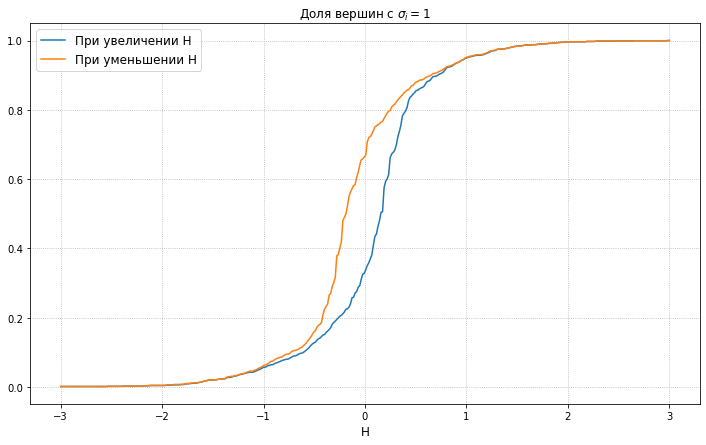

In [252]:
low_to_high_fractions = []
for H in tqdm(H_grid):
    new_state = get_stable_state(G, H, J)
    low_to_high_fractions.append(np.mean(new_state + 1) / 2)
plt.figure(figsize=(12, 7))
plt.grid(ls=':')
plt.xlabel('H', fontsize='large')
plt.title(r'Доля вершин с $\sigma_i = 1$')
plt.plot(H_grid, low_to_high_fractions, label="При увеличении H");

high_to_low_fractions = []
for H in tqdm(np.flip(H_grid)):
    new_state = get_stable_state(G, H, J)
    high_to_low_fractions.append(np.mean(new_state + 1) / 2)
plt.plot(np.flip(H_grid), high_to_low_fractions, label='При уменьшении H');
plt.legend(fontsize='large');

Переходы и правда стали более резкими — видимо, из-за того, что соседние вершины более "связаны", они могут поменять своё состояние лишь сразу всей группой, в то время как в первой части более вероятны переходы отдельных вершин даже с большой степенью. Кроме того, можно заметить, что петля немного сдвинута вправо от нуля (впрочем, возможно, это какой-то случайный эффект). Само же разделение траекторий начинается, как и в первой части, при $|H| \approx 1$, а при малых по модулю $H$ наблюдаются два возможных положения равновесия.

### Как именно устанавливаются положения равновесия?

Рассмотрим следующую задачу. Пусть изначально все $\sigma_i = -1$, но $H$ фиксировано и близко к $0$, так что это состояние не является равновесным. Оно, однако, будет постепенно сходиться к какому-то положению равновесия:
1. Сначала поменяют своё состояние те агенты, для которых $H + H_i - Jk > 0$ — они желают быть "положительными" вне зависимости от того, что выбирают их соседи.
2. Потом поменяют своё состояние те их соседи, для перехода которых в положительное состояние достаточно одной положительной смежной вершины, т.е. те, для которых $H + H_i - J(k - 1) > 0$. Также возможна ситуация, когда какая-то вершина смежна сразу с несколькими сменившими состояние на первом шаге, и для неё достаточно имеющегося количества положительных соседей — тогда она тоже сменит состояние на этом шаге.
3. Затем добавятся соседи вершин, развернувшихся на втором шаге, для которых уже есть необходимая доля положительных соседей, и т.д.  

Таким образом, процесс перехода вершин в положительное состояние начинается с отдельных "центров" и постепенно распространяется от них по всему графу. Посмотрим, как именно происходит этот процесс: какие доли вершин становятся положительными на разных шагах.

In [329]:
N = 10000
H = 0
J = 0.2
new_fractions = []

In [330]:
G = RandomPoissonGraph(N, l)
G.sample_fields()

In [331]:
G.set_state(-np.ones(G.N))

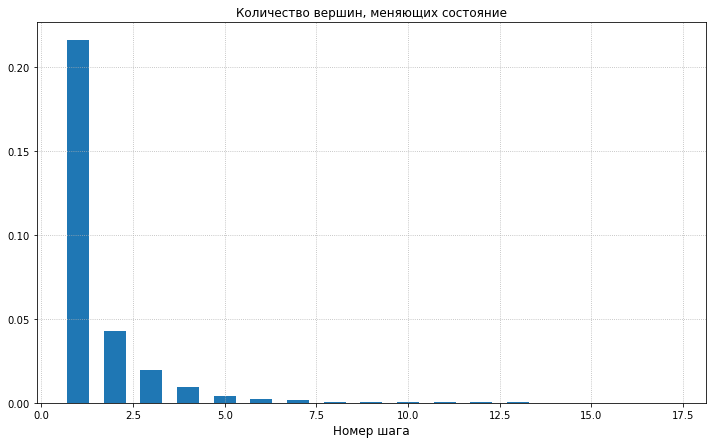

In [332]:
current_state = G.state
next_state = G.get_next_state(H, J)
while not np.allclose(current_state, next_state):
    new_fractions.append(np.mean(next_state - current_state) / 2)
    current_state = next_state
    next_state = G.get_next_state(H, J)
plt.figure(figsize=(12, 7))
plt.grid(ls=':')
plt.xlabel('Номер шага', fontsize='large')
plt.title(r'Количество вершин, меняющих состояние')
plt.bar(range(1, len(new_fractions) + 1), new_fractions, width=0.6);

Очень много вершин меняют своё состояние на первом же шаге, после чего изменения довольно быстро затухают, за 10-20 шагов сходясь к равновесному состоянию. Стало быть, влияние соседей оказывается не столь сильным, в основном состояние агента определяется его индивидуальным полем $H_i$. Попробуем увеличить константу $J$, отвечающую за силу взаимодействия:

In [334]:
J = 1

In [335]:
G = RandomPoissonGraph(N, l)
G.sample_fields(sps.norm(loc=0, scale=3))
G.set_state(-np.ones(G.N))

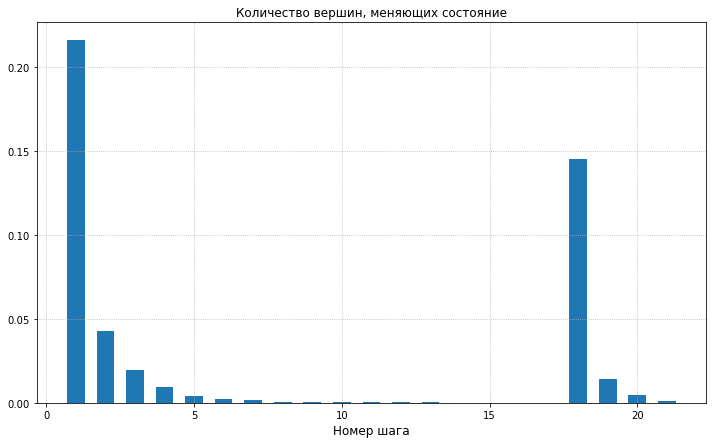

In [336]:
current_state = G.state
next_state = G.get_next_state(H, J)
while not np.allclose(current_state, next_state):
    new_fractions.append(np.mean(next_state - current_state) / 2)
    current_state = next_state
    next_state = G.get_next_state(H, J)
plt.figure(figsize=(12, 7))
plt.grid(ls=':')
plt.xlabel('Номер шага', fontsize='large')
plt.title(r'Количество вершин, меняющих состояние')
plt.bar(range(1, len(new_fractions) + 1), new_fractions, width=0.6);

Как видно, ситуация приниципиально поменялась — появились 2 волны "переворачивания" спинов, выглядящие так же, как на в первой ситуации: довольно много вершин переворачиваются на первом шаге, а потом процесс довольно быстро затухает. Вершины с $\sigma_i = +1$ постепенно скапливаются, после чего наступает вторая волна, в которой также довольно большая доля вершин меняет своё состояние.

Почему же появляется вторая волна? Вероятно, в конце первой волны складывается ситуация, в которой какой-то отдельный кластер вершин ещё не сменил состояние, но близок к этому. После этого одна из его вершин меняет своё состояние, и этого оказывается достаточно, чтобы на следующем шаге весь этот кластер тоже изменил его — здесь уже, в отличие от первого случая, виден эффект, связанный с сильным влиянием соседей. Далее вершины этого кластера, в свою очередь, вызывают изменения у соседей, и процесс дальше распространяется по графу, как и при первой волне.